# Default of Credit Card Clients Dataset

In [1]:
## https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib.pylab import plt

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing, metrics
from sklearn.metrics import accuracy_score
from numpy import corrcoef, sum, log, arange
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing,cross_validation, svm, neighbors
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import itertools

df = pd.read_csv('UCI_Credit_Card.csv')
df.columns = df.columns.str.lower()
df.drop('id', axis=1, inplace=True) # we do not need id

C:\Users\filipe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df['sex'] = df['sex'].map({2:'female', 1:'male'})
df['marriage'] = df['marriage'].map({1:'married', 2:'single', 3:'other', 0: 'other'}) 
df['education'] = df['education'].map({1:'graduate school', 2:'university', 3:'high school', 4:'others', 5:'unknown', 6:'unknown', 0:'unknown'})

df['pay_0'] = df['pay_0'].astype(str) 
df['pay_2'] = df['pay_2'].astype(str) 
df['pay_3'] = df['pay_3'].astype(str) 
df['pay_4'] = df['pay_4'].astype(str) 

df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default.payment.next.month
0,20000.0,female,university,married,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,female,university,single,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,female,university,single,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,female,university,married,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,male,university,married,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
X = pd.get_dummies(df[df.columns[:-1]],columns=['sex','marriage','education','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6'])
y = df[df.columns[-1]]
features = X.columns

scaler = preprocessing.StandardScaler()
X = scaler.fit(X).transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)

In [6]:
clfs = {'NaiveBayes': GaussianNB(),
        'RandomForest': RandomForestClassifier(n_estimators=50),
        'KNN' : KNeighborsClassifier(n_neighbors=5),
        'DT' : DecisionTreeClassifier(random_state=0),
        'GradientBoosting': GradientBoostingClassifier(learning_rate= 0.05, max_depth= 6,
                                                        n_estimators=200, max_features = 0.3,
                                                        min_samples_leaf = 5)
        }

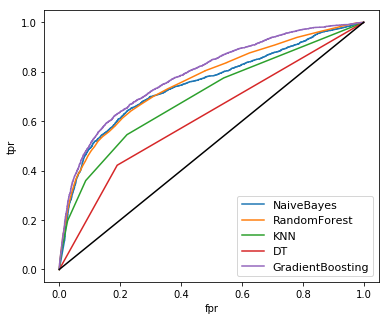

In [7]:
cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score', 'accuracy']
models_report = pd.DataFrame(columns = cols)
feature_importance = pd.DataFrame()

conf_matrix = dict()

for clf, clf_name in zip(clfs.values(), clfs.keys()):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:,1]
    
    if (clf_name == 'RandomForest') | (clf_name == 'GradientBoosting'):
        tmp_fi = pd.Series(clf.feature_importances_)
        feature_importance[clf_name] = tmp_fi
        

    tmp = pd.Series({ 
                     'model': clf_name,
                     'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                     'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                     'precision_score': metrics.precision_score(y_test, y_pred),
                     'recall_score': metrics.recall_score(y_test, y_pred),
                     'f1_score': metrics.f1_score(y_test, y_pred),
                     'accuracy': metrics.accuracy_score(y_test, y_pred)},
                   )

    models_report = models_report.append(tmp, ignore_index = True)

    conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)

    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

    plt.figure(1, figsize = (6,5))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.plot(fpr, tpr, label = clf_name)
    plt.legend(prop={'size':11})
plt.plot([0,1], [0,1], c = 'black')
plt.show()

In [8]:
models_report

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,accuracy
0,NaiveBayes,0.215454,0.749249,0.658385,0.119639,0.202483,0.791250
1,RandomForest,0.391699,0.761816,0.655827,0.364184,0.468312,0.816833
2,KNN,0.319751,0.698883,0.541030,0.359669,0.432090,0.790583
3,DT,0.224639,0.615762,0.386818,0.421746,0.403528,0.723833
4,GradientBoosting,0.410322,0.788185,0.687898,0.365688,0.477524,0.822750


In [9]:
def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=35)

    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=35)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

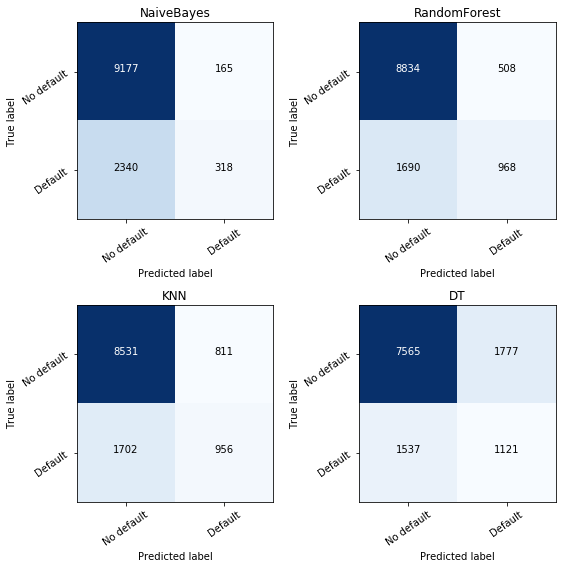

In [10]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 8)) 
gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

for c, ax in zip(conf_matrix.keys(), [ax1,ax2,ax3,ax4]):
    plot_confusion_matrix(conf_matrix[c].values, ax, title = c, classes=['No default','Default'])

plt.tight_layout()
plt.show()

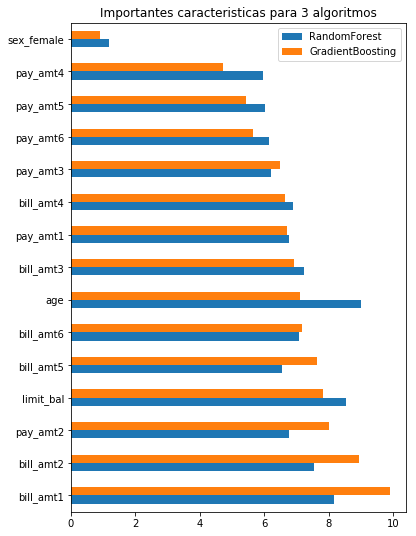

In [11]:
fi = feature_importance

fi.index = features
fi = fi.head(15) #15 mais importantes caracteristicas
fi = fi.sort_values('GradientBoosting', ascending=False)
fi = (fi / fi.sum(axis=0)) * 100
fi.plot.barh(title = 'Importantes caracteristicas para 3 algoritmos', figsize = (6,9))

In [ ]:
#referências:
#https://www.kaggle.com/tasalta/credit-default-analysis-over-different-sets
#https://www.kaggle.com/vincepota/modelling-default-customers-with-scikit-learn